## 1. Environment Setup & Data Ingestion
Briefly mention the data source and environment requirements.

In [6]:
# ENVIRONMENT CHECK & SETUP
# This project requires NumPy < 2.0 and SHAP < 0.46 for compatibility.
# If you encounter import errors, uncomment and run the lines below:

# !pip install "numpy<2" "shap<0.46"
# import os; os._exit(00) # Restart kernel automatically after installation

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data ingestion
file_path = 'data/cs-training.csv'
df = pd.read_csv(file_path, index_col=0)

# Quick validation
print(df.head())
print(df.info())

   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   

## 2. Visual Inspection & Data Sanitization
Visualize distributions to identify structural skews. This step is crucial for identifying data-entry errors (e.g., impossible income figures) before implementing cleaning strategies.

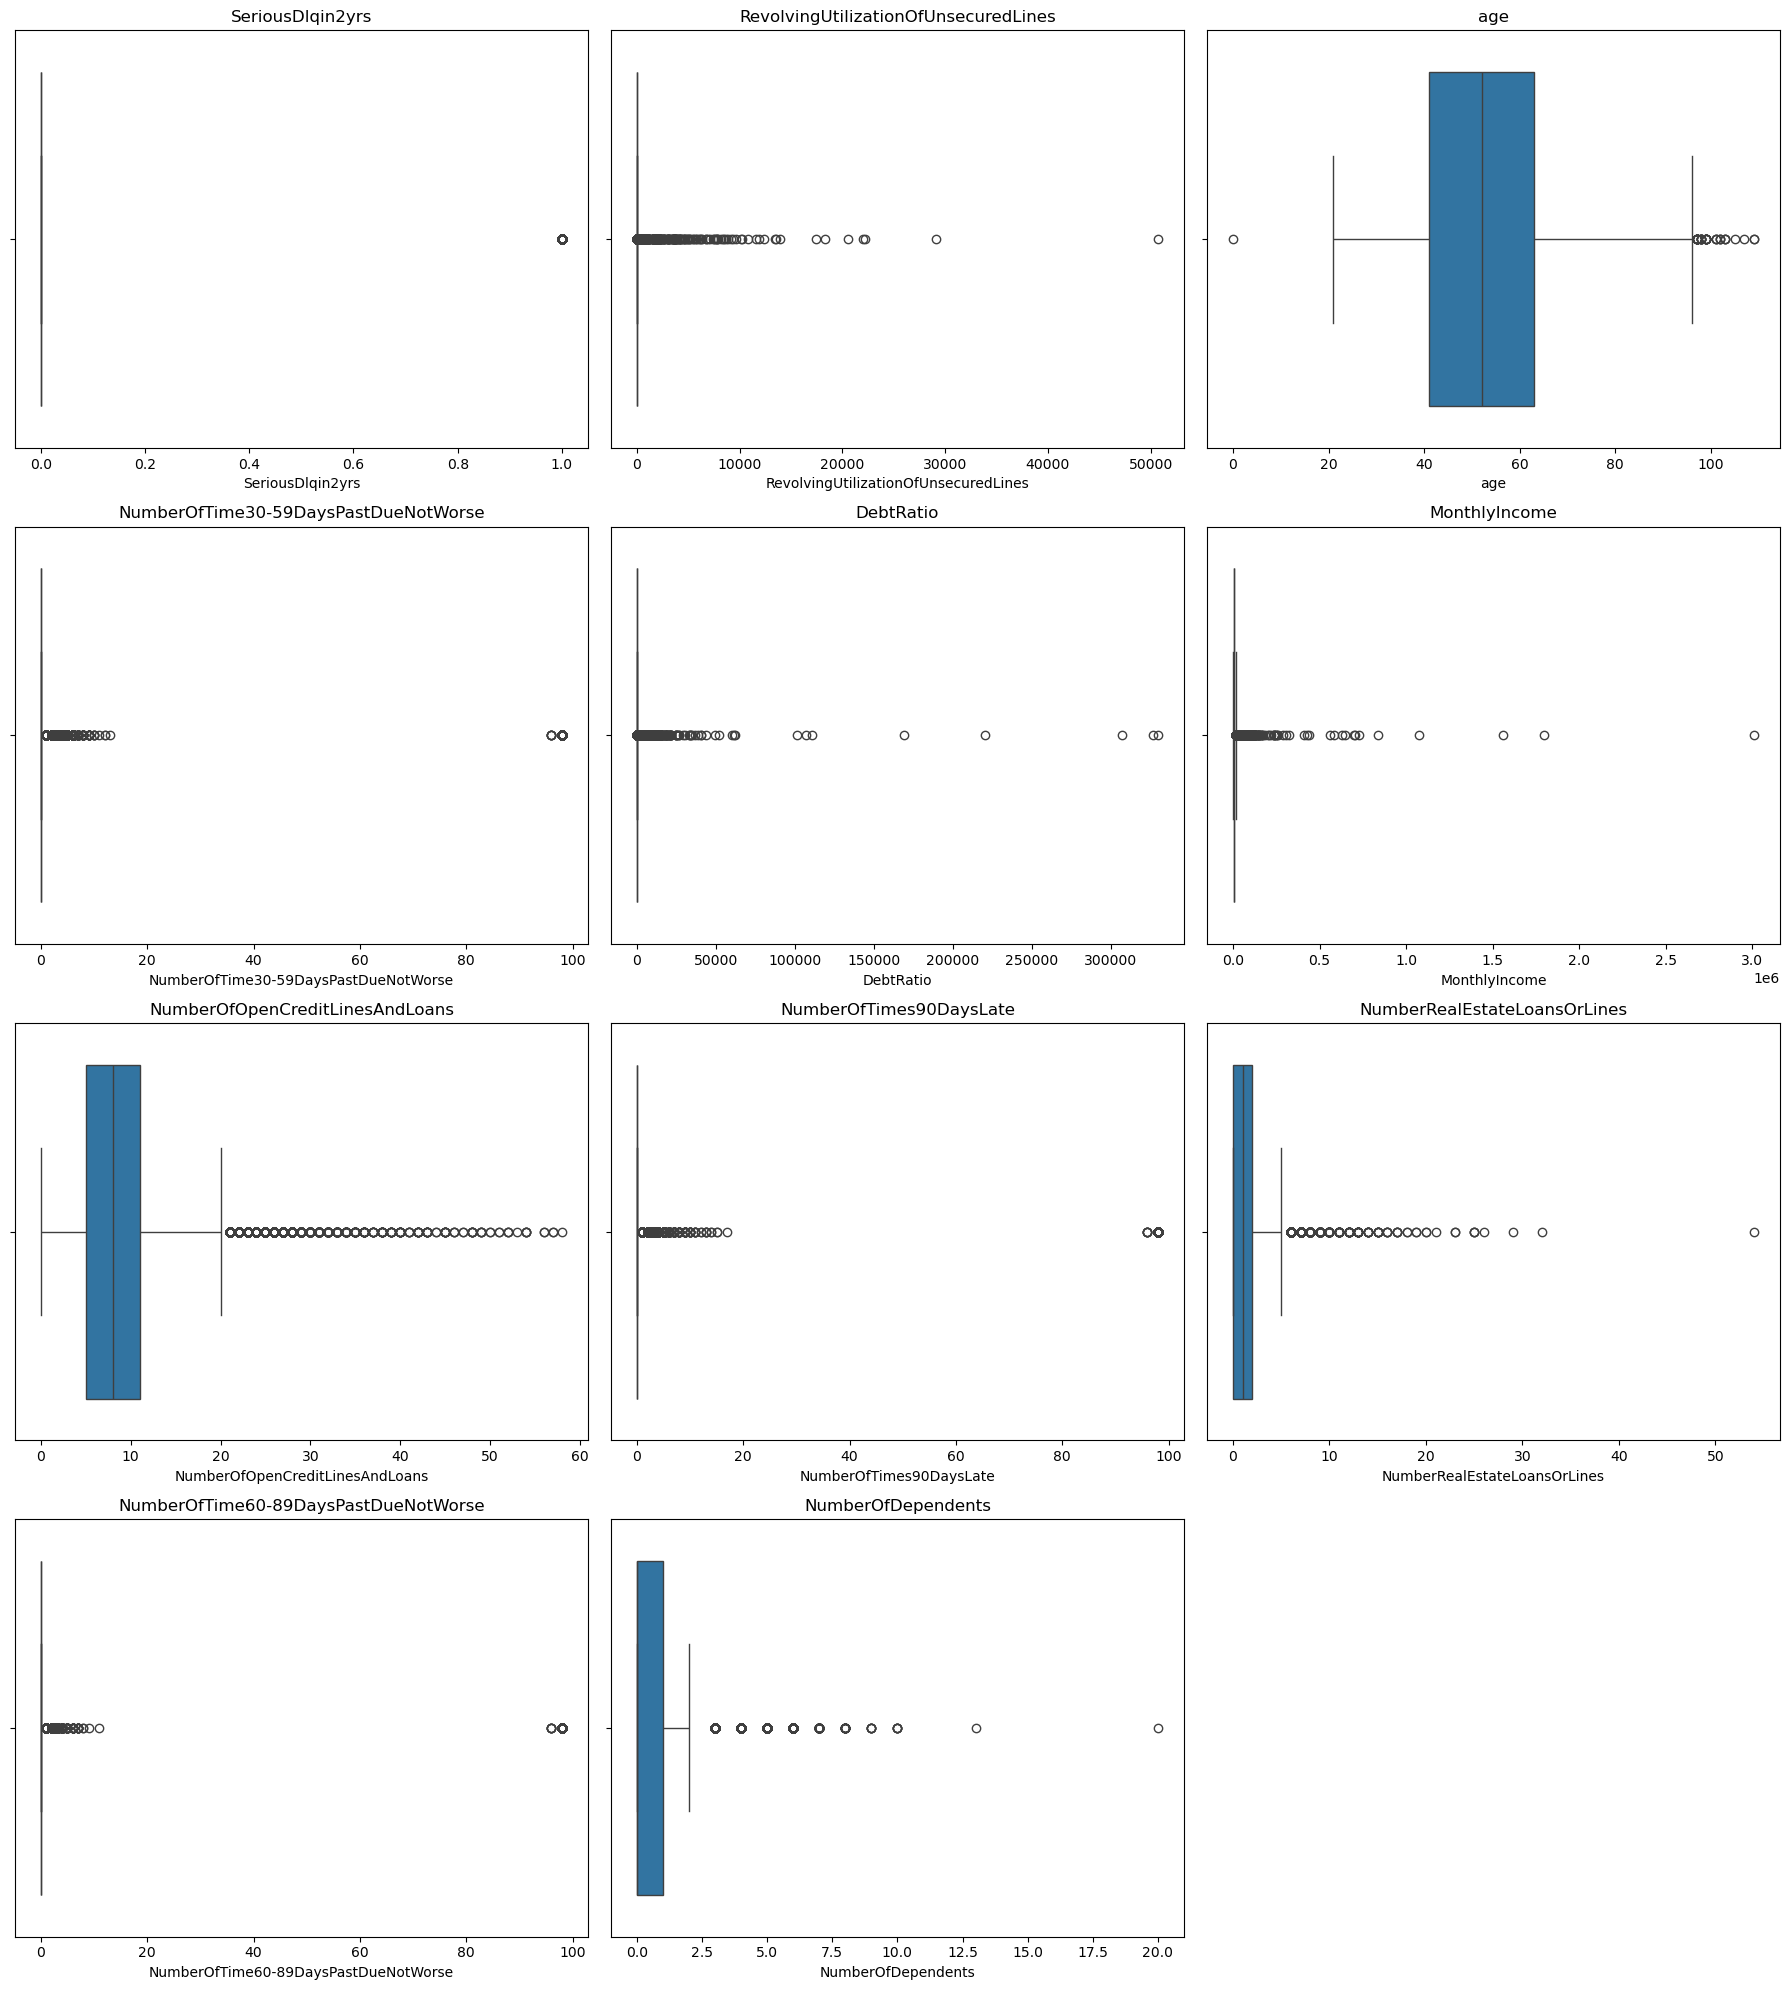

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize all 11 original features for comprehensive inspection
cols = df.columns.tolist()

# 2. Setup a 4x3 grid to visualize all distributions in a single pass
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
axes = axes.flatten()

# 3. Iterate through all features using basic boxplots to detect outliers and scale issues
for i, col in enumerate(cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)

# 4. Clean up the final empty subplot for a professional layout
if len(cols) < len(axes):
    plt.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Target Inspection of Anomalous Features

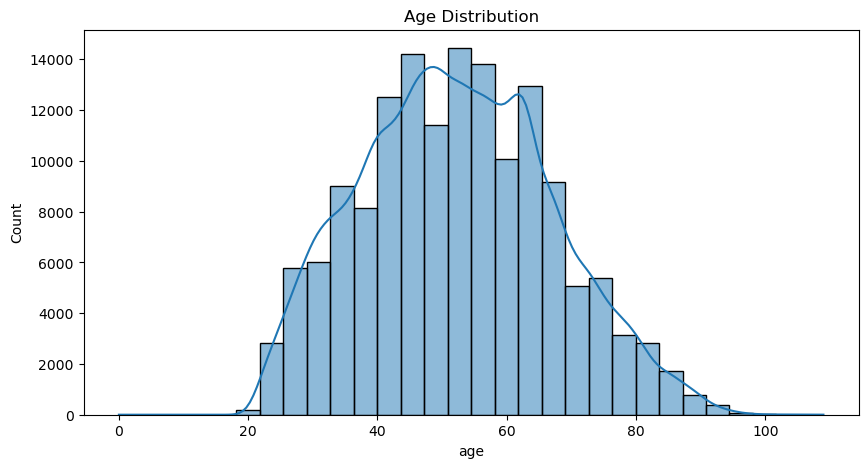

In [8]:
# Visualize distributions for key features

fig, ax = plt.subplots(figsize=(10, 5)) 

# Age distribution analysis
sns.histplot(df['age'], bins=30, kde=True, ax=ax) 
ax.set_title('Age Distribution')

plt.show()


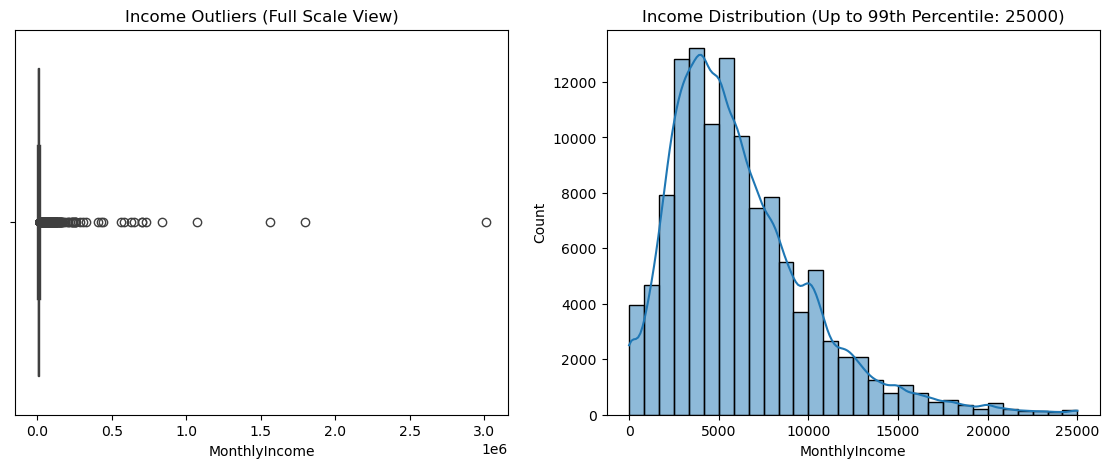

In [9]:
# Use a dynamic quantile-based threshold for visualization
upper_threshold = df['MonthlyIncome'].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# View 1: Full Scale
sns.boxplot(x=df['MonthlyIncome'], ax=axes[0])
axes[0].set_title('Income Outliers (Full Scale View)')

# View 2: Density View (Capped at 99th percentile for clarity)
# This removes the extreme 1% noise to show the main population distribution
main_dist = df[df['MonthlyIncome'] <= upper_threshold]['MonthlyIncome']
sns.histplot(main_dist, bins=30, kde=True, ax=axes[1])
axes[1].set_title(f'Income Distribution (Up to 99th Percentile: {upper_threshold:.0f})')

plt.show()

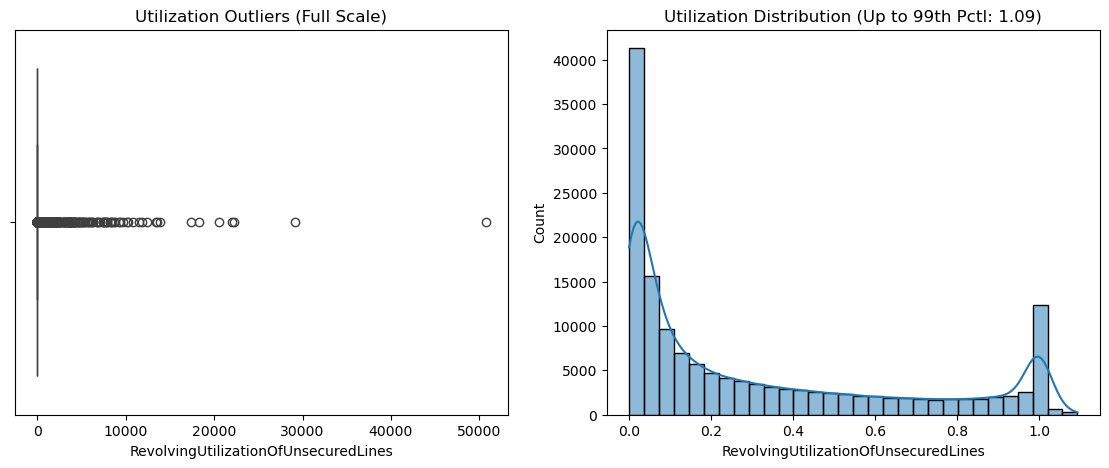

In [10]:

# Check for anomalies in Credit Utilization (Balance / Limit)
# Dynamic threshold for Credit Utilization (99th percentile)
util_threshold = df['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# View 1: Full Scale Outlier Detection
sns.boxplot(x=df['RevolvingUtilizationOfUnsecuredLines'], ax=axes[0])
axes[0].set_title('Utilization Outliers (Full Scale)')

# View 2: Distribution of the Majority (Capped at 99th Percentile)
# This reveals the behavior of 99% of the population
util_main = df[df['RevolvingUtilizationOfUnsecuredLines'] <= util_threshold]['RevolvingUtilizationOfUnsecuredLines']
sns.histplot(util_main, bins=30, kde=True, ax=axes[1])
axes[1].set_title(f'Utilization Distribution (Up to 99th Pctl: {util_threshold:.2f})')

plt.show()

Quantitative Validation of Structural Anomalies

In [11]:
# Check specific logical boundaries identified in the audit
print(f"Applicants aged 0: {df[df['age'] == 0].shape[0]}")
print(f"Applicants aged > 100: {df[df['age'] > 100].shape[0]}")

# Verify the 96/98 synchronization across behavioral columns
behavioral_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
for col in behavioral_cols:
    special_count = df[df[col] >= 96].shape[0]
    print(f"{col} - Records with 96/98 codes: {special_count}")

# Check high-capacity outliers
print(f"Max Real Estate Loans: {df['NumberRealEstateLoansOrLines'].max()}")
print(f"Max Dependents: {df['NumberOfDependents'].max()}")

Applicants aged 0: 1
Applicants aged > 100: 13
NumberOfTime30-59DaysPastDueNotWorse - Records with 96/98 codes: 269
NumberOfTimes90DaysLate - Records with 96/98 codes: 269
NumberOfTime60-89DaysPastDueNotWorse - Records with 96/98 codes: 269
Max Real Estate Loans: 54
Max Dependents: 20.0


### Data Audit: Key Quantitative Findings
The statistical check confirms that while the majority of the data follows expected distributions, there are critical logical anomalies and systemic encodings that must be addressed:

A. Logical Inconsistencies & Entry Errors
Age Anomalies: We identified 1 record with age = 0, a definitive data-entry failure for a credit product. However, there are 13 records for applicants aged 100–110. Given the absence of values > 110, these senior profiles are treated as statistically rare but biologically plausible.

Physical Extremes: The maximum values for NumberRealEstateLoansOrLines (54) and NumberOfDependents (20) represent extreme financial and household profiles. While physically possible, their extreme magnitude can exert undue leverage on model gradients.

B. Systemic Status Encodings (The "98" Pattern)
Synchronized Codes: A recurring cluster of 269 records with values 96 and 98 exists across all three delinquency features (NumberOfTime...).

Inference: The perfect synchronization of these counts across different time horizons confirms these are internal systemic codes (e.g., "unknown status" or "frozen account") rather than actual late-payment counts.

C. Preprocessing Decisions
Corrective Imputation: Replace age = 0 with the dataset median.

Strategic Retention: Keep the 96/98 codes and high-age records (100–110), as they likely contain high-value risk signals that tree-based models can effectively isolate.

Numerical Stabilization: Apply 99th percentile Winsorization to continuous variables (Utilization, Income, DebtRatio, and high-count capacity features) to neutralize noise while preserving the "Extreme" signal.

## 3. Feature Engineering & Preprocessing
We implement a targeted strategy to transform raw audit findings into robust model inputs:

Indicator Creation: Developed binary flags for missing MonthlyIncome and absolute DebtRatio structures to capture latent risk signals.

Special Status Encoding: Isolated synchronized 96/98 codes into a unique Is_Special_Status feature to separate categorical anomalies from linear counts.

Targeted Correction: Rectified age = 0 entry errors while preserving biologically plausible senior profiles (100–110 years).

Numerical Stabilization: Applied 99th percentile Winsorization to stabilize extreme noise in utilization and capacity features, ensuring model gradient stability.

In [12]:
import numpy as np  

def preprocess_for_ml(data):
    df_clean = data.copy()
    
    # A. Missing Value Indicators
    df_clean['MonthlyIncome_NA'] = df_clean['MonthlyIncome'].isnull().astype(int)
    df_clean['NumberOfDependents_NA'] = df_clean['NumberOfDependents'].isnull().astype(int)
    
    # B. Special Status Encoding (The "96/98" Pattern)
    # 269 records show synchronized codes across delinquency features
    df_clean['Is_Special_Status'] = (df_clean['NumberOfTimes90DaysLate'] >= 96).astype(int)
    
    # C. Demographic & Debt Structural Adjustments
    # Correcting 1 instance of age=0 to median; keeping senior ages (100-110)
    df_clean.loc[df_clean['age'] < 18, 'age'] = df_clean['age'].median()
    # Flagging records where DebtRatio is likely an absolute value due to missing income
    df_clean['Is_DebtRatio_Abs'] = ((df_clean['MonthlyIncome'].isnull()) | (df_clean['MonthlyIncome'] == 0)).astype(int)
    
    # D. Imputation
    df_clean['MonthlyIncome'] = df_clean['MonthlyIncome'].fillna(df_clean['MonthlyIncome'].median())
    df_clean['NumberOfDependents'] = df_clean['NumberOfDependents'].fillna(0)
    
    # E. Universal Winsorization (99th percentile capping)
    # Stabilizing heavy-tailed features including high-count capacity variables
    cols_to_cap = [
        'RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 
        'NumberRealEstateLoansOrLines', 'NumberOfDependents'
    ]
    for col in cols_to_cap:
        upper_limit = df_clean[col].quantile(0.99)
        df_clean[col] = np.where(df_clean[col] > upper_limit, upper_limit, df_clean[col])
        
    return df_clean

# Execute optimized preprocessing
df_ml = preprocess_for_ml(df)

check new data

In [13]:
# 1. Dimension Check: Verify original vs processed dataset
# Note: Shape will change due to new feature engineering (e.g., Is_Special_Status)
print(f"Original shape: {df.shape}")
print(f"Processed shape: {df_ml.shape}")

# 2. Nullity Check: Ensure zero missing values remain
print(f"\nTotal missing values: {df_ml.isnull().sum().sum()}")

# 3. Anomaly Verification: Check if specific issues were resolved
print("\n--- Diagnostic Verification ---")
print(f"Min Age (Should be >= 18): {df_ml['age'].min()}")
print(f"Special Status Records Flagged: {df_ml['Is_Special_Status'].sum()}")

# 4. Winsorization Validation: Check all capped features
cols_to_check = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 
                 'MonthlyIncome', 'NumberRealEstateLoansOrLines', 'NumberOfDependents']
print("\nFeature Max Values (Post-Capping):")
print(df_ml[cols_to_check].max())

Original shape: (150000, 11)
Processed shape: (150000, 15)

Total missing values: 0

--- Diagnostic Verification ---
Min Age (Should be >= 18): 21
Special Status Records Flagged: 269

Feature Max Values (Post-Capping):
RevolvingUtilizationOfUnsecuredLines        1.092956
DebtRatio                                4979.040000
MonthlyIncome                           23000.000000
NumberRealEstateLoansOrLines                4.000000
NumberOfDependents                          4.000000
dtype: float64


## 4. Model Benchmarking: Raw vs. Optimized
To quantify the impact of our diagnostic-driven preprocessing, we benchmark two Random Forest (RF) models under identical hyperparameter settings. This comparison isolates the predictive value added by manual feature engineering and outlier management.

Experimental Setup:

Model A (Baseline): Minimal preprocessing—only basic imputation is applied to ensure the model runs.

Model B (Optimized): Comprehensive pipeline—incorporates Special Status encoding, error correction (Age=0), and Universal Winsorization.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# --- Group A: Minimal Preprocessing (Raw-ish) ---
def simple_preprocess(data):
    df_simple = data.copy()
    # Only fill NA to allow the model to run
    df_simple['MonthlyIncome'] = df_simple['MonthlyIncome'].fillna(df_simple['MonthlyIncome'].median())
    df_simple['NumberOfDependents'] = df_simple['NumberOfDependents'].fillna(0)
    return df_simple

# --- Group B: Manual Optimization  ---

# Prepare datasets
df_a = simple_preprocess(df)
df_b = preprocess_for_ml(df)

# Train-Test Split
X_a, y_a = df_a.drop('SeriousDlqin2yrs', axis=1), df_a['SeriousDlqin2yrs']
X_b, y_b = df_b.drop('SeriousDlqin2yrs', axis=1), df_b['SeriousDlqin2yrs']

# use the same random_state to ensure fair comparison
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Model Training
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Evaluating Model A
rf.fit(X_train_a, y_train_a)
auc_a = roc_auc_score(y_test_a, rf.predict_proba(X_test_a)[:, 1])

# Evaluating Model B
rf.fit(X_train_b, y_train_b)
auc_b = roc_auc_score(y_test_b, rf.predict_proba(X_test_b)[:, 1])

print(f"Model A (Baseline) AUC: {auc_a:.4f}")
print(f"Model B (Optimized) AUC: {auc_b:.4f}")
print(f"Improvement: {(auc_b - auc_a):.4f}")

Model A (Baseline) AUC: 0.8621
Model B (Optimized) AUC: 0.8641
Improvement: 0.0020


Precision Tuning: Identifying the Optimal Ranking Equilibrium (0.1 - 2.0)

In [15]:
# Fine-grained search around the current peak
fine_weights = np.linspace(0.1, 2.0, 20)
fine_auc_scores = []

for w in fine_weights:
    rf_fine = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight={0: 1, 1: w},
        random_state=42,
        n_jobs=-1
    )
    rf_fine.fit(X_train_b, y_train_b)
    score = roc_auc_score(y_test_b, rf_fine.predict_proba(X_test_b)[:, 1])
    fine_auc_scores.append(score)
    print(f"Weight 1:{w:.2f} | AUC: {score:.4f}")


Weight 1:0.10 | AUC: 0.8603
Weight 1:0.20 | AUC: 0.8622
Weight 1:0.30 | AUC: 0.8624
Weight 1:0.40 | AUC: 0.8628
Weight 1:0.50 | AUC: 0.8630
Weight 1:0.60 | AUC: 0.8631
Weight 1:0.70 | AUC: 0.8630
Weight 1:0.80 | AUC: 0.8636
Weight 1:0.90 | AUC: 0.8633
Weight 1:1.00 | AUC: 0.8642
Weight 1:1.10 | AUC: 0.8639
Weight 1:1.20 | AUC: 0.8638
Weight 1:1.30 | AUC: 0.8637
Weight 1:1.40 | AUC: 0.8633
Weight 1:1.50 | AUC: 0.8636
Weight 1:1.60 | AUC: 0.8627
Weight 1:1.70 | AUC: 0.8634
Weight 1:1.80 | AUC: 0.8634
Weight 1:1.90 | AUC: 0.8630
Weight 1:2.00 | AUC: 0.8630


## Calibrating XGBoost with Asymmetric Weights (1.0 - 10.0)
This step optimizes Model C by adjusting the scale_pos_weight to enhance the gradient signal for minority defaults on our audited dataset.

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Define the range of weights for XGBoost (focusing on the 1 to 10 range)
xgb_weights = np.linspace(1, 10, 10)
xgb_auc_scores = []

print("Starting weight optimization for XGBoost (Model C)...")

for w in xgb_weights:
    xgb_temp = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        scale_pos_weight=w,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc',
        n_jobs=-1
    )
    
    xgb_temp.fit(X_train_b, y_train_b)
    score = roc_auc_score(y_test_b, xgb_temp.predict_proba(X_test_b)[:, 1])
    xgb_auc_scores.append(score)
    print(f"XGB Weight {w:.1f} | AUC: {score:.4f}")

# Identify the optimal weight for XGB
best_xgb_weight = xgb_weights[np.argmax(xgb_auc_scores)]
best_xgb_auc = max(xgb_auc_scores)

print(f"\nXGBoost Optimization Complete.")
print(f"Best XGB Weight: {best_xgb_weight:.1f} | Peak AUC: {best_xgb_auc:.4f}")

Starting weight optimization for XGBoost (Model C)...
XGB Weight 1.0 | AUC: 0.8638
XGB Weight 2.0 | AUC: 0.8640
XGB Weight 3.0 | AUC: 0.8643
XGB Weight 4.0 | AUC: 0.8641
XGB Weight 5.0 | AUC: 0.8643
XGB Weight 6.0 | AUC: 0.8643
XGB Weight 7.0 | AUC: 0.8640
XGB Weight 8.0 | AUC: 0.8643
XGB Weight 9.0 | AUC: 0.8644
XGB Weight 10.0 | AUC: 0.8641

XGBoost Optimization Complete.
Best XGB Weight: 9.0 | Peak AUC: 0.8644


In [19]:
# Define explicit search range to prevent variable overlap from previous loops
actual_fine_range = np.linspace(8.0, 10.0, 21) 
final_xgb_scores = []

print("Running Corrected Fine-grained Optimization (8.0 - 10.0)...")

for w in actual_fine_range:
    # Initialize XGBoost with specific scale_pos_weight for each iteration
    xgb_final = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        scale_pos_weight=w,        # Tuning the penalty for the minority class
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc',         # Focus on ranking performance (AUC)
        n_jobs=-1
    )
    
    # Train on the optimized feature set (Group B)
    xgb_final.fit(X_train_b, y_train_b)
    
    # Evaluate performance on the validation set
    score = roc_auc_score(y_test_b, xgb_final.predict_proba(X_test_b)[:, 1])
    final_xgb_scores.append(score)
    print(f"XGB Weight {w:.2f} | AUC: {score:.4f}")

# Identify the champion weight that maximizes AUC
absolute_best_w = actual_fine_range[np.argmax(final_xgb_scores)]
print(f"\nReal Optimal Weight: {absolute_best_w:.2f}")

Running Corrected Fine-grained Optimization (8.0 - 10.0)...
XGB Weight 8.00 | AUC: 0.8643
XGB Weight 8.10 | AUC: 0.8643
XGB Weight 8.20 | AUC: 0.8642
XGB Weight 8.30 | AUC: 0.8642
XGB Weight 8.40 | AUC: 0.8642
XGB Weight 8.50 | AUC: 0.8644
XGB Weight 8.60 | AUC: 0.8643
XGB Weight 8.70 | AUC: 0.8644
XGB Weight 8.80 | AUC: 0.8642
XGB Weight 8.90 | AUC: 0.8644
XGB Weight 9.00 | AUC: 0.8644
XGB Weight 9.10 | AUC: 0.8643
XGB Weight 9.20 | AUC: 0.8644
XGB Weight 9.30 | AUC: 0.8642
XGB Weight 9.40 | AUC: 0.8641
XGB Weight 9.50 | AUC: 0.8641
XGB Weight 9.60 | AUC: 0.8644
XGB Weight 9.70 | AUC: 0.8640
XGB Weight 9.80 | AUC: 0.8640
XGB Weight 9.90 | AUC: 0.8643
XGB Weight 10.00 | AUC: 0.8641

Real Optimal Weight: 8.70


## Strategic Ensemble: Weighted Blending of Bagging and Boosting
This final stage optimizes the fusion ratio between Model B and Model C to minimize algorithmic bias. By blending their complementary predictive patterns, we achieve a robust "Master Model" with maximized generalization performance.

Searching for the optimal Ensemble Ratio...
------------------------------
Ensemble Optimization Complete!
Optimal Ratio: 0.73 RF + 0.27 XGB
Peak Ensemble AUC: 0.8649
------------------------------


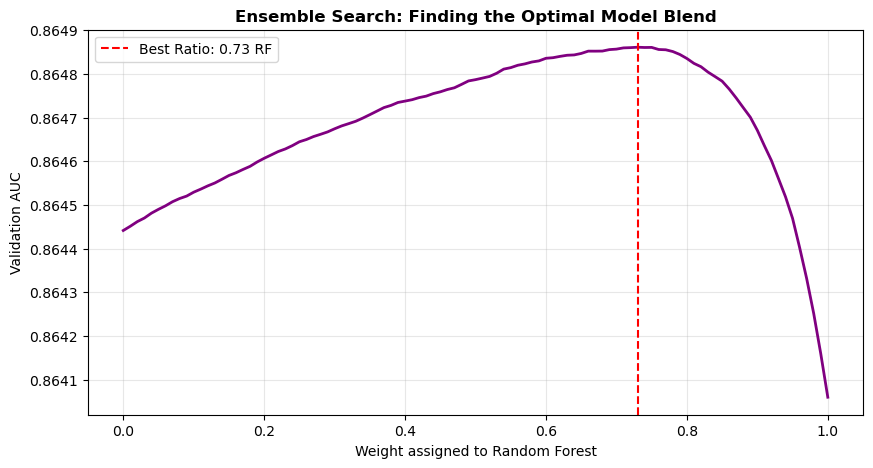

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# --- Re-initialize the two Champion Models with the best parameters ---

# Model B: Optimized Random Forest (Standard Weighting as discovered)
best_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
best_rf.fit(X_train_b, y_train_b)
rf_probs = best_rf.predict_proba(X_test_b)[:, 1]

# Model C: Champion XGBoost (Optimized Weight = 8.70)
xgb_champion = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.05,
    scale_pos_weight=8.70, subsample=0.8, colsample_bytree=0.8,
    random_state=42, eval_metric='auc', n_jobs=-1
)
xgb_champion.fit(X_train_b, y_train_b)
xgb_probs = xgb_champion.predict_proba(X_test_b)[:, 1]

# --- Search for the optimal Ensemble Ratio ---
# Logic: r * RF_Prob + (1 - r) * XGB_Prob
ratios = np.linspace(0, 1, 101)  # 0%, 1%, ..., 100% RF
ensemble_auc_scores = []

print("Searching for the optimal Ensemble Ratio...")

for r in ratios:
    blended_probs = (r * rf_probs) + ((1 - r) * xgb_probs)
    score = roc_auc_score(y_test_b, blended_probs)
    ensemble_auc_scores.append(score)

# --- Find the "Sweet Spot" ---
best_ratio_idx = np.argmax(ensemble_auc_scores)
best_rf_weight = ratios[best_ratio_idx]
best_xgb_weight = 1 - best_rf_weight
max_ensemble_auc = ensemble_auc_scores[best_ratio_idx]

print("-" * 30)
print(f"Ensemble Optimization Complete!")
print(f"Optimal Ratio: {best_rf_weight:.2f} RF + {best_xgb_weight:.2f} XGB")
print(f"Peak Ensemble AUC: {max_ensemble_auc:.4f}")
print("-" * 30)

# --- Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(ratios, ensemble_auc_scores, color='purple', lw=2)
plt.axvline(best_rf_weight, color='red', linestyle='--', label=f'Best Ratio: {best_rf_weight:.2f} RF')
plt.title('Ensemble Search: Finding the Optimal Model Blend', fontweight='bold')
plt.xlabel('Weight assigned to Random Forest')
plt.ylabel('Validation AUC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Final Production Output: Generating Submissions for Models A, B, C, & D
This final execution block synthesizes the entire project by generating competitive probability scores for the official Kaggle test set. It exports four distinct CSV files, allowing for a step-by-step verification of the performance gains achieved through data auditing, algorithmic optimization, and model ensembling.

In [21]:
# ---------------------------------------------------------
# FINAL PRODUCTION INFERENCE (A, B, C, & D)
# ---------------------------------------------------------

# 1. Load the official test dataset
# Note: Ensure path matches your local environment
df_test_official = pd.read_csv('data/cs-test.csv')

# --- Feature Preparation ---
# Minimal preprocessing for the Baseline
X_test_a = simple_preprocess(df_test_official).drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1, errors='ignore')

# Advanced preprocessing for Optimized models
X_test_opt = preprocess_for_ml(df_test_official).drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1, errors='ignore')

# ---------------------------------------------------------
# MODEL A: Baseline Random Forest
# ---------------------------------------------------------
rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_baseline.fit(X_a, y_a)
prob_a = rf_baseline.predict_proba(X_test_a)[:, 1]

# ---------------------------------------------------------
# MODEL B: Optimized Random Forest
# ---------------------------------------------------------
rf_optimized = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_optimized.fit(X_b, y_b)
prob_b = rf_optimized.predict_proba(X_test_opt)[:, 1]

# ---------------------------------------------------------
# MODEL C: Champion XGBoost (Weight=8.70)
# ---------------------------------------------------------
xgb_champion = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.05,
    scale_pos_weight=8.70, subsample=0.8, colsample_bytree=0.8,
    random_state=42, eval_metric='auc', n_jobs=-1
)
xgb_champion.fit(X_b, y_b)
prob_c = xgb_champion.predict_proba(X_test_opt)[:, 1]

# ---------------------------------------------------------
# MODEL D: Weighted Ensemble (The best Model)
# ---------------------------------------------------------

prob_d = (best_rf_weight * prob_b) + (best_xgb_weight * prob_c)

# ---------------------------------------------------------
# EXPORTING FINAL SUBMISSIONS
# ---------------------------------------------------------
def save_kaggle_submission(probs, filename):
    submission = pd.DataFrame({
        'Id': range(1, len(probs) + 1),
        'Probability': probs
    })
    submission['Id'] = submission['Id'].astype(int)
    submission.to_csv(filename, index=False)
    print(f"File Saved: {filename} | Rows: {len(submission)}")

save_kaggle_submission(prob_a, 'submission_model_a_baseline.csv')
save_kaggle_submission(prob_b, 'submission_model_b_optimized_rf.csv')
save_kaggle_submission(prob_c, 'submission_model_c_champion_xgb.csv')
save_kaggle_submission(prob_d, 'submission_model_d_ensemble_final.csv')

File Saved: submission_model_a_baseline.csv | Rows: 101503
File Saved: submission_model_b_optimized_rf.csv | Rows: 101503
File Saved: submission_model_c_champion_xgb.csv | Rows: 101503
File Saved: submission_model_d_ensemble_final.csv | Rows: 101503


Ensemble Wrapper for model d

In [22]:
import numpy as np

class ModelDEnsemble:
    """
    Champion Ensemble Model (Model D) 
    Combines Optimized Random Forest and XGBoost using pre-defined weights.
    """
    def __init__(self, rf_model, xgb_model, rf_weight, xgb_weight):
        self.rf_model = rf_model
        self.xgb_model = xgb_model
        self.rf_weight = rf_weight
        self.xgb_weight = xgb_weight

    def predict_proba(self, X):
        """Returns the weighted probability of default (Class 1)."""
        p_rf = self.rf_model.predict_proba(X)[:, 1]
        p_xgb = self.xgb_model.predict_proba(X)[:, 1]
        return (self.rf_weight * p_rf) + (self.xgb_weight * p_xgb)

    def predict(self, X, threshold=0.5):
        """Returns binary classification based on a strategic threshold."""
        probs = self.predict_proba(X)
        return (probs > threshold).astype(int)

# --- Initialization ---
# Assuming best_rf_weight and best_xgb_weight were found in previous steps
model_d = ModelDEnsemble(
    rf_optimized, 
    xgb_champion, 
    best_rf_weight, 
    best_xgb_weight
)

## 5.Ensemble Interpretation
Synthesizing Drivers from RF and XGBoostThis visualization aggregates feature importance scores weighted by optimal model

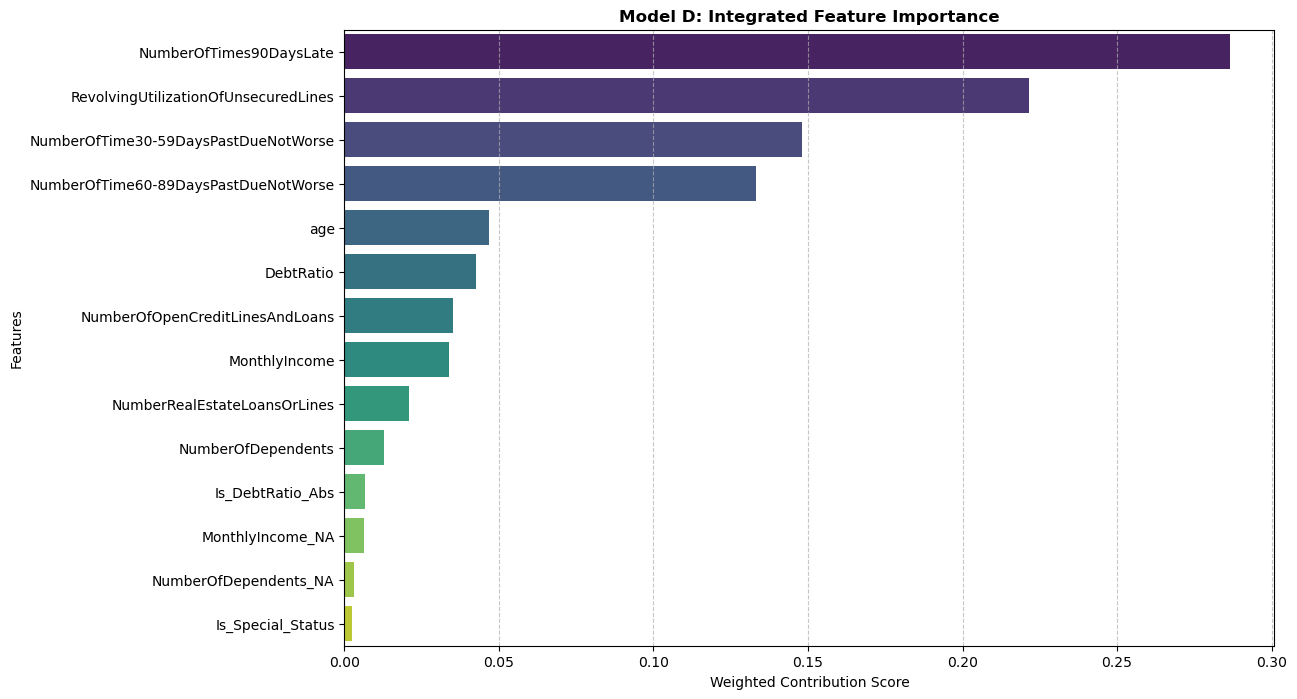

In [23]:
# 1. Calculate Weighted Importance using the Class attributes
ensemble_importances = (model_d.rf_weight * model_d.rf_model.feature_importances_) + \
                       (model_d.xgb_weight * model_d.xgb_model.feature_importances_)

# 2. Prepare DataFrame
feature_names = X_test_opt.columns
ensemble_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ensemble_importances
}).sort_values(by='Importance', ascending=False)

# 3. Visualization: Using a standard color map to avoid alerts
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=ensemble_importance_df, 
    hue='Feature',      # Setting hue to 'Feature' avoids the palette warning
    legend=False,       # Hide legend since it's redundant here
    palette='viridis'   # Using 'viridis' which is universally supported
)

plt.title(f'Model D: Integrated Feature Importance', fontweight='bold')
plt.xlabel('Weighted Contribution Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

For SHAP interpretability, we analyse the RF component (best_rf) only as a simplification.

SHAP values shape: (500, 14)
SHAP value range: [-0.0592, 0.3110]
Mean SHAP per feature (first 3): [-0.00073832 -0.0005074  -0.00192454]


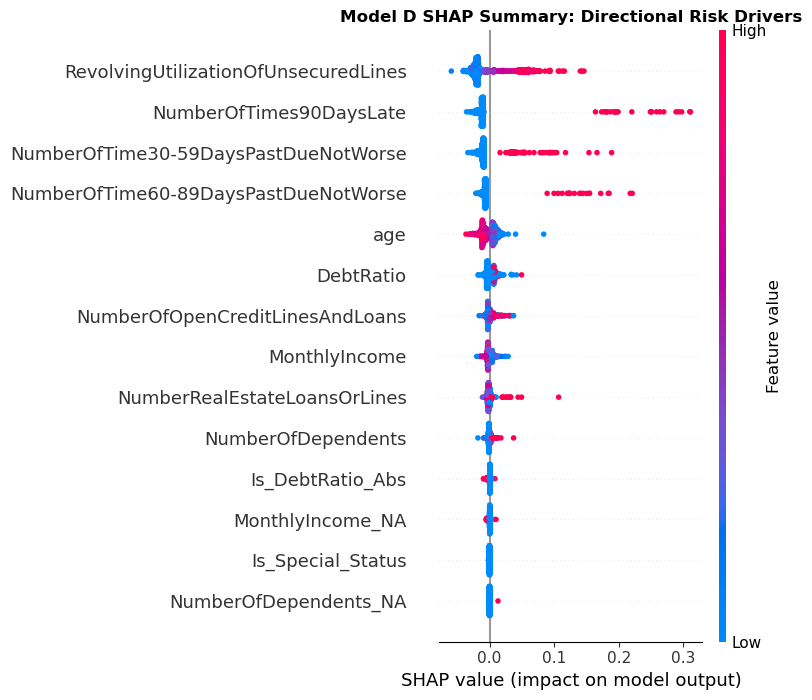


--- Model D: Quantitative Feature Impact Report ---
                             Feature  Importance    Direction
RevolvingUtilizationOfUnsecuredLines    0.028701 Positive (+)
             NumberOfTimes90DaysLate    0.024079 Positive (+)
NumberOfTime30-59DaysPastDueNotWorse    0.018079 Positive (+)
NumberOfTime60-89DaysPastDueNotWorse    0.013288 Positive (+)
                                 age    0.009573 Negative (-)
                           DebtRatio    0.005508 Positive (+)
     NumberOfOpenCreditLinesAndLoans    0.003996 Positive (+)
                       MonthlyIncome    0.003778 Negative (-)
        NumberRealEstateLoansOrLines    0.002717 Positive (+)
                  NumberOfDependents    0.001887 Positive (+)
                    Is_DebtRatio_Abs    0.001206 Negative (-)
                    MonthlyIncome_NA    0.000885 Negative (-)
                   Is_Special_Status    0.000147     Constant
               NumberOfDependents_NA    0.000073 Positive (+)


C:\Users\SC2zh\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\SC2zh\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [30]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# --- 1. Explainer & SHAP values ---
explainer = shap.TreeExplainer(model_d.rf_model)
X_sample = X_test_b.iloc[:500, :]
shap_values_raw = explainer.shap_values(X_sample, check_additivity=False)

# --- 2. Extract correctly WITHOUT negation ---
if isinstance(shap_values_raw, list):
    actual_shap_values = shap_values_raw[1]   # class 1 = default
elif shap_values_raw.ndim == 3:
    actual_shap_values = shap_values_raw[:, :, 1]
else:
    actual_shap_values = shap_values_raw

print(f"SHAP values shape: {actual_shap_values.shape}")
print(f"SHAP value range: [{actual_shap_values.min():.4f}, {actual_shap_values.max():.4f}]")
print(f"Mean SHAP per feature (first 3): {actual_shap_values.mean(0)[:3]}")

# --- 3. Plot ---
plt.figure(figsize=(12, 10))
shap.summary_plot(
    actual_shap_values, 
    X_sample, 
    feature_names=feature_names,
    show=False
)
plt.title("Model D SHAP Summary: Directional Risk Drivers", fontweight='bold')
plt.tight_layout()
plt.show()

# --- 4. Directional analysis ---
importance_magnitude = np.abs(actual_shap_values).mean(0)
directional_analysis = []

for i, col in enumerate(X_test_b.columns):
    col_vals = X_sample.iloc[:, i].values
    shap_col = actual_shap_values[:, i]  # guaranteed 1D now
    
    corr_matrix = np.corrcoef(col_vals, shap_col)
    corr_val = corr_matrix[0, 1]
    
    if np.isnan(corr_val):
        direction = "Constant"
    else:
        direction = "Positive (+)" if corr_val > 0 else "Negative (-)"
        
    directional_analysis.append({
        'Feature': col,
        'Importance': importance_magnitude[i],
        'Direction': direction
    })

# --- 5. Final report ---
df_final_audit = pd.DataFrame(directional_analysis).sort_values('Importance', ascending=False)
print("\n--- Model D: Quantitative Feature Impact Report ---")
print(df_final_audit.to_string(index=False))

**Quantitative Audit**: This analysis evaluates the trade-offs between **Type I Error (FPR)** and **Type II Error (FNR)** to determine the optimal probability cut-off for credit approval.
    * **Type I Error**: Represents the risk of incorrectly rejecting creditworthy clients, leading to lost interest income and customer friction.
    * **Type II Error**: Represents the failure to identify potential defaults, leading to direct principal losses and increased provision requirements (ECL).
* **Strategic Calibration**: By iterating through thresholds (0.5 to 0.1), we use 0.2 as threshold of model D to balance the risk and cost.

Threshold    | Type I (FPR)    | Type II (FNR)   | Recall    
------------------------------------------------------------
0.5          | 1.37%           | 66.77%          | 33.23%    
0.2          | 12.86%          | 28.37%          | 71.63%    
0.1          | 32.30%          | 11.96%          | 88.04%    


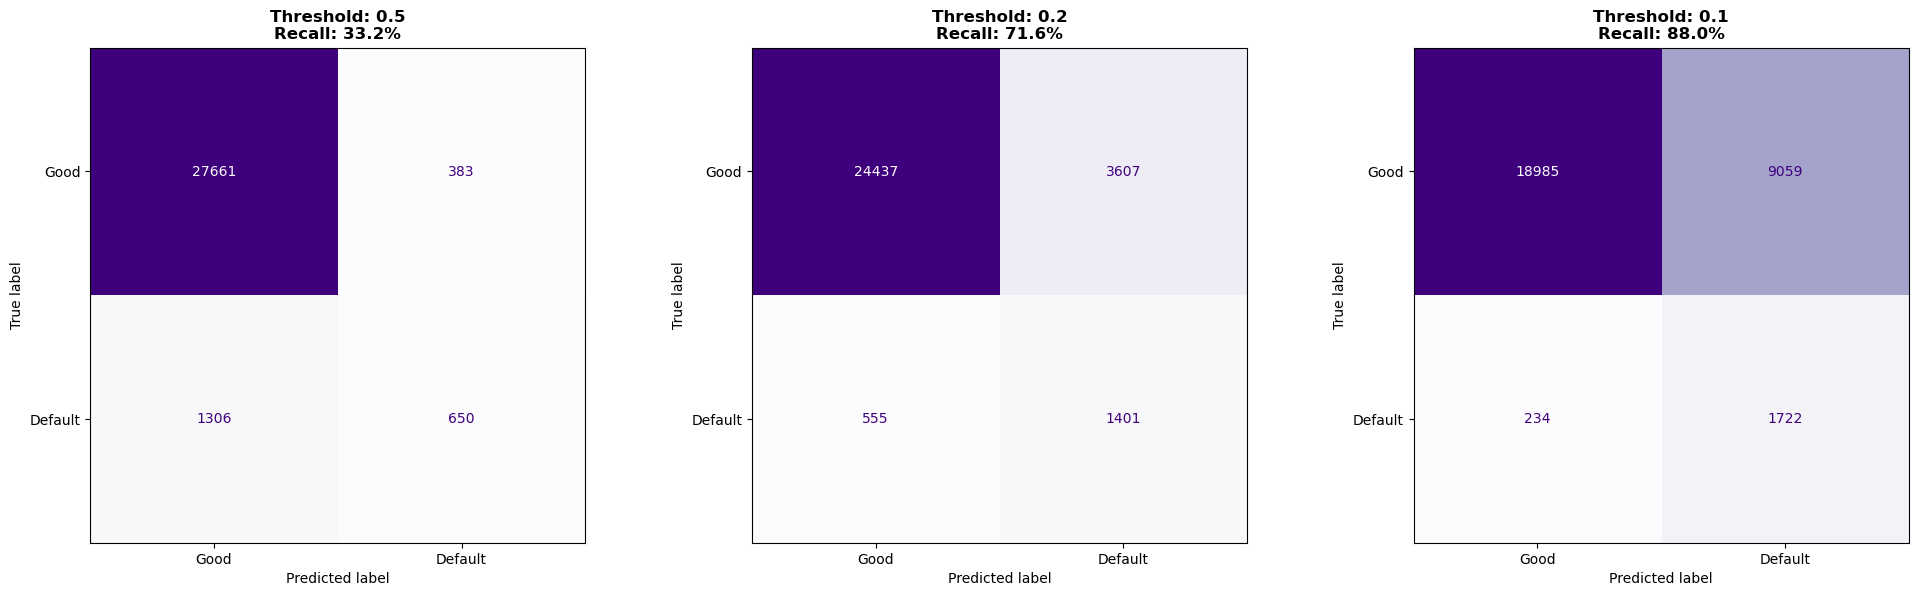

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Define thresholds for sensitivity analysis
thresholds = [0.5, 0.2, 0.1]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 2. Direct call to Model D's probability method
# This uses the encapsulated logic from our class
val_probs_d = model_d.predict_proba(X_test_b)

print(f"{'Threshold':<12} | {'Type I (FPR)':<15} | {'Type II (FNR)':<15} | {'Recall':<10}")
print("-" * 60)

for i, ax in enumerate(axes):
    t = thresholds[i]
    
    # 3. Use the class's built-in predict method with custom threshold
    y_pred_t = model_d.predict(X_test_b, threshold=t)
    
    # 4. Metrics calculation
    cm = confusion_matrix(y_test_b, y_pred_t)
    tn, fp, fn, tp = cm.ravel()
    
    type_i = fp / (fp + tn)   # False Positive Rate (Targeting good clients)
    type_ii = fn / (fn + tp)  # False Negative Rate (Missing defaults)
    recall = tp / (tp + fn)   # Default Capture Rate
    
    print(f"{t:<12.1f} | {type_i:<15.2%} | {type_ii:<15.2%} | {recall:<10.2%}")
    
    # 5. Plotting Confusion Matrices
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good', 'Default'])
    disp.plot(ax=ax, cmap='Purples', colorbar=False)
    ax.set_title(f"Threshold: {t}\nRecall: {recall:.1%}", fontweight='bold')

plt.tight_layout()
plt.show()